# How to use this interactive notebook?

#### 1. Fill in your API key below
#### 2. Press the play button above or select _Run All Cells_ from the _Run_ menu in the toolbar.

In [1]:
API_KEY = "your-api-key-here"

# Use Case

**This use case accompanies the whitepaper "[How to compare different ship performance models?](https://toqua.ai/whitepapers/how-to-compare-different-ship-performance-models)". We recommend reading through the whitepaper first.**

This whitepaper provides a framework to compare different ship performance models fairly. To recap, these are the broad steps of the framework:

> 1. **First, we establish a benchmark dataset**
> 
> This dataset will provide the ‘ground truth’ of measured values that the models should try to estimate. It should be free of errors and constrained to sea-going conditions.
> 
> 2. **Next we determine a set of quantitative metrics**
> 
> To measure how accurate the models are it is important to have meaningful, robust and quantifiable metrics. It is important that all metrics are calculated on exact same dataset.
> 
> 3. **Finally, we benchmark the results**
> 
> We compare our obtained quantitative metrics against each other to determine the most accurate model.


This use case will demonstrate how steps 1 and 2 of the framework can be executed on a Toqua Ship Kernel. Step 3 can be done by comparing the obtained results against other models.

## Setup
Fill in the IMO number of your ship below.

In [2]:
IMO_NUMBER = "9999999"

## Helper functions

Some helper functions to not clutter our code too much later on.

In [3]:
import logging
from time import sleep
from typing import Dict
import pandas as pd
import requests

def make_api_call(method, url, payload=None, return_json=True):
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "X-API-Key": API_KEY,
    }
    
    if method == 'GET':
        response = requests.get(url, headers=headers)
    elif method == 'POST':
        response = requests.post(url, json=payload, headers=headers)
    else:
        print("Error: Invalid method")
        return None
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        logging.error(f"Error: {e}")
        logging.error(response.content)
        raise e
    if return_json:
        return response.json()
    return response

# 1. Establish a benchmark dataset

As first step, we establish a dataset on which models can be benchmarked. This dataset will provide the ‘ground truth’ of measured values that the models should try to estimate. It should be free of errors and constrained to sea-going conditions. It is important that **this exact same dataset** is used for all models. 

Creating such a benchmarking dataset is done by following this five-step process:
   1. Choosing a data source (sensor data or noon reports)
   2. Choosing an evaluation period
   3. Filtering outliers
   4. Filtering unaccounted for external effects
   5. Constraining to sea-going conditions

We will go through each of these steps in turn.

## 1. Choosing a data source

The first step is to determine which data source to use. Usually this comes down to the decision between using noon reports or sensor data. Sensor data is preferred as it significantly higher frequency than noon reports and is most accurate, given that data quality is properly monitored.

For illustration purposes, we've generated two toy datasets: one sensor dataset containing all parameters required by our Ship Kernel, and one dataset containing cleaning events.

Let's have a look at these datasets.

In [4]:
df = pd.read_csv("data/ship_data.csv", parse_dates=["datetime_end"])
df

,datetime_end,voyage,stw,me_fo_consumption,ship_heading,wind_direction,wind_speed,wave_direction,wave_height,current_speed,current_direction,fuel_specific_energy,draft_avg,sea_depth
0,2022-12-13 07:15:00+00:00,7,13.057588,51.876791,82.611714,83.905523,9.903634,190.080503,2.530389,0.332442,68.983909,41.520901,19.267722,3684.521953
1,2022-12-13 07:30:00+00:00,7,12.497633,48.108068,156.384608,86.209823,10.019390,213.902484,1.978841,0.247596,95.548815,41.484348,19.042159,3925.727652
2,2022-12-13 07:45:00+00:00,7,12.266902,49.132856,111.089132,161.974538,6.188774,164.351608,2.058779,0.365042,216.490509,41.495188,19.304775,4558.385421
3,2022-12-13 08:00:00+00:00,7,12.447567,51.565374,86.507111,234.302854,5.990013,182.221381,2.762102,0.203695,207.336968,41.494372,19.608763,3431.481687
4,2022-12-13 08:15:00+00:00,7,12.604443,52.874925,101.969993,187.876140,7.359217,174.951579,2.595160,0.360893,182.131579,41.503436,19.446714,3590.116803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15495,2023-05-23 17:00:00+00:00,16,13.131276,56.142710,92.909256,95.774750,4.085990,161.278733,2.968610,0.959770,31.462510,41.784785,19.995170,2334.092171
15496,2023-05-23 17:15:00+00:00,16,13.527832,50.110980,76.086368,130.710602,2.561913,124.201935,1.152197,0.514824,216.608553,41.818291,20.129935,1989.125802
15497,2023-05-23 17:30:00+00:00,16,12.317498,45.715111,106.472531,88.059732,3.946632,145.795403,0.781254,0.628606,107.423500,41.683009,19.407238,-56.975324
15498,2023-05-23 17:45:00+00:00,16,13.891875,62.314616,51.594543,137.685305,3.038406,271.616981,3.170597,0.511956,-0.046838,41.730682,20.170169,738.028456


In [5]:
df.describe()

,voyage,stw,me_fo_consumption,ship_heading,wind_direction,wind_speed,wave_direction,wave_height,current_speed,current_direction,fuel_specific_energy,draft_avg,sea_depth
count,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000,15500.000000
mean,12.064516,12.024822,39.370238,152.564508,139.841184,6.074875,158.503597,1.619031,0.316207,158.007505,41.509984,15.845674,3210.739982
std,3.330665,1.303100,14.031470,88.446652,88.733278,2.543104,81.067008,0.772028,0.233122,93.642129,0.098310,4.853075,1689.790224
min,7.000000,4.650659,-1.913165,-256.327882,-274.864471,-4.346691,-149.833531,-1.670006,-0.988009,-275.934039,40.068560,2.542408,-2098.354212
25%,10.000000,11.623503,27.406763,77.943875,71.606251,4.449684,93.585698,1.057181,0.174851,92.789833,41.492935,9.860883,2030.069123
50%,12.000000,12.337673,41.950648,128.233190,122.314085,6.002787,170.813219,1.603957,0.294347,157.802091,41.500332,19.079024,3546.565538
75%,15.000000,12.848901,51.238161,226.371546,199.895855,7.664628,213.115277,2.122230,0.439336,222.850010,41.507919,19.810468,4406.865624
max,16.000000,15.853633,70.385622,432.026710,534.737811,18.755160,537.639459,5.648308,2.047373,529.753733,43.066129,28.320943,10298.437276


We see there's about 7 months of data, with 15min between each sample. All parameters necessary for our Ship Kernel are present. 

The dataset also contains some obvious erroneous values such as negative values for parameters that obviously cannot be negative (sea depth, wave height, fuel consumption, ...). Finally, an indication of a voyage number is also given.

In [6]:
df_events = pd.read_csv("data/ship_events.csv", parse_dates=["datetime"])
df_events

,datetime,type
0,2023-01-19,hull_cleaning
1,2023-04-23,esd


The ship had a hull cleaning on 19 January 2023 and an ESD installed on 23 April 2023.

## 2. Choosing an evaluation period

Next, we have to choose an evaluation period. This is a period during which the ship performance is stable. That is, it should be free from long idling periods, cleaning events, dry-dockings or ESD-installations. To get a good estimate of how good the model is, it should also be as long as possible.

To determine an appropriate evaluation period we will create a small plot visualizing the events and the STW over time, colored per voyage. This will give us an adequate indication of when the ship is idling. In actual situations you might want to look at more robust indicators of idling such as the ship location, SOG or RPM. 

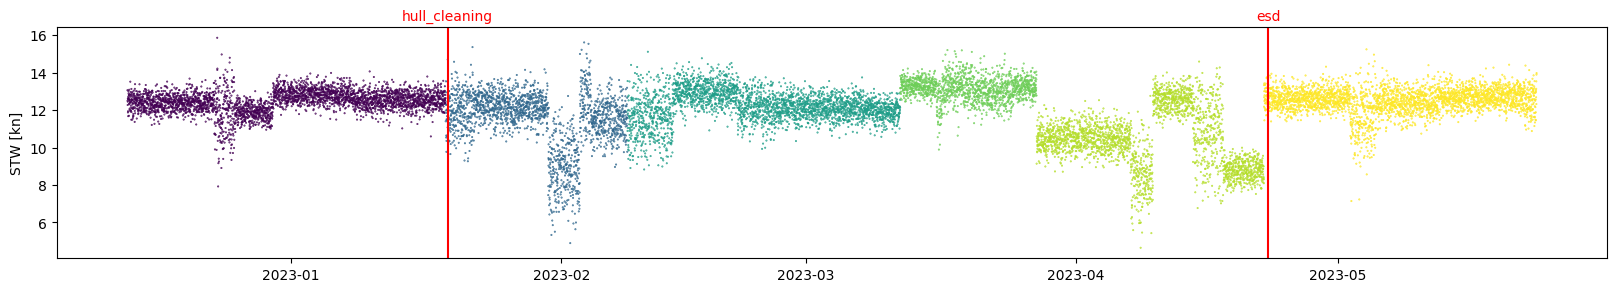

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
ax.scatter(df["datetime_end"], df["stw"], c=df["voyage"], s=0.2)
ax.set_ylabel("STW [kn]")
for event in df_events.itertuples():
    ax.axvline(event.datetime, color="red")
    ax.text(event.datetime, y=1.03, s=event.type, color="red", transform=ax.get_xaxis_transform(), horizontalalignment='center')

Based on the above graph, a good evaluation period would be the period between the hull cleaning and the ESD installation. No long idling periods are present so we may assume ship performance is stable, i.e. no fouling has occurred.

This gives us about 4 months, spanning 4 voyages, of data to evaluate on. Ideally, aim for at least 2 months.

In [8]:
period_filters = [
    "datetime_end > '2023-01-19T00:00+00:00'", # keep only data after hull cleaning
    "datetime_end < '2023-04-23T00:00+00:00'"  # keep only data before esd
]

 # apply each filter in turn using .query method
for f in period_filters:
    df = df.query(f)

## 3. Filtering outliers

Outliers are data points that are significantly different from the rest of the data. They can be caused by sensor errors, human errors, or other external factors. We can filters outliers using advanced outlier detection algorithms, or by applying simple thresholds.

In this case, we will apply a set of very simple thresholds. These thresholds filter out data points that are obviously erroneous. 
For example: directions must be between 0 and 360 degrees, fuel consumption cannot be below 0 and sea depth cannot be below 0.

From knowledge of the ship we also know that she can only sail between a draft of 9 and 20m and never uses fuels with an LCV value below 40 MJ/kg.

Be wary that these simple filters definitely do not capture all outliers.

In [19]:
outlier_filters = [
    "stw > 0",
    "me_fo_consumption > 0",
    "fuel_specific_energy > 40",
    "9 < draft_avg < 20",
    "0 < ship_heading < 360",
    "0 < wind_direction < 360",
    "wind_speed > 0",
    "0 < wave_direction < 360",
    "wave_height > 0",
    "0 < current_direction < 360",
    "current_speed > 0",
    "sea_depth > 0",
]

for f in outlier_filters:
    df = df.query(f)

## 4. Filtering unaccounted for external effects

Next, we filter out samples that are affected by external factors which are not accounted for by the model. These are factors the model "has no idea about". In this case, our Ship Kernel takes into acount all parameters of the dataset except sea depth. I.e. sea depth is not an input of the model. However, a shallow sea can does result in a perceived decrease in performance due to additional drag. As this effect is not accounted for by the model we will filter out samples with a sea depth below 3 * the draft.

If available, we recommended to also filter out extreme rudder angles or temperatures below 5°C.

In [21]:
external_effect_filters = [
    "sea_depth > 3 * draft_avg"
]

for f in external_effect_filters:
    df = df.query(f)

## 5. Constraining to sea-going conditions

Finally, we remove any conditions during which the vessel is not in normal operation conditions (e.g. during port stay, maneuvring, etc.).
For this we will use the following filters:
* Speed > 5 kn
* Fuel Consumption > 5 mt/day

In [22]:
sea_condition_filters = [
    "stw > 5",
    "me_fo_consumption > 5",
]

for f in sea_condition_filters:
    df = df.query(f)


Finally, the following benchmark dataset remains:

In [23]:
df.describe()

,voyage,stw,me_fo_consumption,ship_heading,wind_direction,wind_speed,wave_direction,wave_height,current_speed,current_direction,fuel_specific_energy,draft_avg,sea_depth
count,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000
mean,12.623461,11.477291,28.019218,217.697782,119.402823,5.877615,135.479516,1.289515,0.360744,169.216830,41.514027,11.506024,3192.949122
std,1.903112,1.482350,10.110180,70.170741,81.491937,2.114447,77.949656,0.543884,0.229826,81.053941,0.110925,3.617474,1534.421947
min,10.000000,5.432257,5.073540,2.670415,0.020677,0.017405,0.539178,0.008153,0.000195,0.311512,40.629788,9.002740,28.537542
25%,12.000000,10.591117,21.347129,210.192577,54.621158,4.499937,69.496513,0.899963,0.199349,108.535887,41.492933,9.588736,2174.390643
50%,12.000000,11.858588,27.224383,226.362638,89.779871,5.729592,122.623988,1.240589,0.318965,168.545928,41.500618,9.835597,3560.136698
75%,15.000000,12.532608,34.416526,264.299220,171.812108,7.213965,198.634600,1.668676,0.480741,228.767431,41.508761,10.240189,4265.197085
max,16.000000,15.356211,65.957438,357.829472,359.962032,14.325627,359.809302,3.862184,2.047373,359.164885,42.888742,19.998672,8866.048465


# 2. Calculate quantitative metrics

To measure how accurate the models are it is important to have meaningful, robust and quantifiable metrics. We will provide an implementation of  the following metrics:
* Mean Absolute Percentage Error (MAPE) 
$$\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left|\frac{\hat{y_i} - y_i}{y_i}\right|$$


* Bias Percentage Error (BPE)
$$\text{BPE} = \frac{\sum_{i}^{N} \hat{y}_{i} - \sum_{j}^{N} y_j}{\sum_{k}^{N} y_k}$$

* Daily Percentage Error (DPE)
$$\text{DPE} = \frac{100}{D} \sum_{d}^{D} \left| \frac{\sum_{i}^{d} \hat{y}_i - y_{i} }{\sum_{j}^{d} y_{j}} \right|$$


* Voyage Error (VE)
$$\text{VE} = \frac{1}{V} \sum_{v}^{V} \left| \frac{100}{v} \sum_{i}^{v} \frac{ \hat{y}_{i} - y_{i} }{y_i} \right|$$

A detailed explanation of these metrics, accompanied by toy examples, may be found in the whitepaper.

In [24]:
import numpy as np

def mape(true, pred):
    """Mean Absolute Percentage Error
    
    true: a list of measured values
    pred: a list of predicted values
    """
    return np.mean(np.abs((pred - true) / true)) * 100

def bpe(true, pred):
    """Bias Percentage Error
    
    true: a list of measured values
    pred: a list of predicted values
    """
    return np.sum(pred - true) / np.sum(true) * 100

def dpe(true, pred, days):
    """Daily Percentage Error
    
    true: a list of measured values
    pred: a list of predicted values
    days: a list of days, corresponding to the day on which the measurement was done
    """
    metrics_per_day = []
    for d in np.unique(days):
        mask = days == d
        metrics_per_day.append(np.abs(bpe(true[mask], pred[mask])))
    return np.mean(metrics_per_day)


def ve(true, pred, voyages):
    """Voyage Error
    
    true: a list of measured values
    pred: a list of predicted values
    voyages: a list of voyage ids, corresponding to the voyage during which the measurement was done
    """
    metrics_per_voyage = []
    for v in np.unique(voyages):
        mask = voyages == v
        metrics_per_voyage.append(np.abs(bpe(true[mask], pred[mask])))
    return np.mean(metrics_per_voyage)

We can use above functions to calculate the metrics, given the ground truth values and the values predicted by the model. The ground truth values we obtain from the benchmark dataset established earlier. All that is left is to obtain the predicted values from the Ship Kernel through the Toqua API.

In [25]:

def predict(imo_number, df):
    """Do a prediction on the Toqua Ship Kernel of a given vessel.
    
    This implementation is a bit more complicated than in previous use cases. Because the Toqua API 
    a maximum of 9000 rows at a time  we need to split the data into chunks of 9000.
    """
    url = f"https://api.toqua.ai/ships/{imo_number}/models/latest/predict"
    
    # toqua API limit
    chunk_size = 9000
    # split the input data into chunks of 9000 rows
    chunks = np.array_split(df, len(df) / chunk_size + 1)
    prediction_chunks = []
    # for each chunk, predict the values
    for chunk in chunks:
        model_input = { "data": chunk.drop(columns=["datetime_end", "me_fo_consumption"]).to_dict(orient="list") }
        pred = make_api_call('POST', url, model_input)
        prediction_chunks.append(pd.DataFrame(pred, index=chunk.index))
    # finally, concatenate the results again
    return pd.concat(prediction_chunks)

In [26]:
df_predictions = predict(IMO_NUMBER, df)

pd.DataFrame([{
    "Mean Absolute Percentage Error": mape(df.me_fo_consumption, df_predictions.me_fo_consumption),
    "Bias Percentage Error": bpe(df.me_fo_consumption, df_predictions.me_fo_consumption),
    "Daily Percentage Error": dpe(df.me_fo_consumption, df_predictions.me_fo_consumption, df.datetime_end.dt.round("1d")),
    "Voyage Error": ve(df.me_fo_consumption, df_predictions.me_fo_consumption, df.voyage)
}])

,Mean Absolute Percentage Error,Bias Percentage Error,Daily Percentage Error,Voyage Error
0,11.294556,2.711311,4.66523,2.659526


We can see that our Ship Kernel has a MAPE of 11.29%, a BPE of 2.71%, a DPE of 4.67% and a Voyage Error of 2.66%.

As expected, as the MAPE is calculated on the shortest time scale (every 15minutes) it has the highest error. The BPE is calculated on the longest time scale (the entire evaluation period) and thus has the lowest error because the errors cancel each other out. It shows that on average, the model has a bias of 2.7%. This bias could be due to hull fouling. When the Ship Kernel is constructed on one part of the data, but then evaluated on a part where it is slightly fouled it will show that as having a higher BPE.
The DPE and VE are calculated on intermediate time scales and fall somewhere in between.

Now all that remains is seeing how these metrics compare to other models.